# Supply Chain Delivery Delay Prediction

## Project Overview

This project aims to predict the risk of delivery delays using historical order and shipping data. The goal is to support proactive logistics decisions by identifying high-risk shipments before they occur..

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Overview

In [2]:
# Load the dataset with correct encoding
df = pd.read_csv("Data/DataCoSupplyChainDataset.csv", encoding='latin1')
df_des = pd.read_csv("Data/DescriptionDataCoSupplyChain.csv", encoding='latin1')

In [3]:
# Preview basic structure and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [4]:
# Check for duplicate rows
df.duplicated().sum()

0

In [5]:
#Check for missing values
df.isnull().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [6]:
#check for unique values in each column
unique_values = {col: df[col].nunique() for col in df.columns}
print(unique_values)

{'Type': 4, 'Days for shipping (real)': 7, 'Days for shipment (scheduled)': 4, 'Benefit per order': 21998, 'Sales per customer': 2927, 'Delivery Status': 4, 'Late_delivery_risk': 2, 'Category Id': 51, 'Category Name': 50, 'Customer City': 563, 'Customer Country': 2, 'Customer Email': 1, 'Customer Fname': 782, 'Customer Id': 20652, 'Customer Lname': 1109, 'Customer Password': 1, 'Customer Segment': 3, 'Customer State': 46, 'Customer Street': 7458, 'Customer Zipcode': 995, 'Department Id': 11, 'Department Name': 11, 'Latitude': 11250, 'Longitude': 4487, 'Market': 5, 'Order City': 3597, 'Order Country': 164, 'Order Customer Id': 20652, 'order date (DateOrders)': 65752, 'Order Id': 65752, 'Order Item Cardprod Id': 118, 'Order Item Discount': 1017, 'Order Item Discount Rate': 18, 'Order Item Id': 180519, 'Order Item Product Price': 75, 'Order Item Profit Ratio': 162, 'Order Item Quantity': 5, 'Sales': 193, 'Order Item Total': 2927, 'Order Profit Per Order': 21998, 'Order Region': 23, 'Order

In [7]:
df_des

,FIELDS,DESCRIPTION
0,Type,: Type of transaction made
1,Days for shipping (real),: Actual shipping days of the purchased product
2,Days for shipment (scheduled),: Days of scheduled delivery of the purchased...
3,Benefit per order,: Earnings per order placed
4,Sales per customer,: Total sales per customer made per customer
5,Delivery Status,: Delivery status of orders: Advance shipping...
6,Late_delivery_risk,: Categorical variable that indicates if send...
7,Category Id,: Product category code
8,Category Name,: Description of the product category
9,Customer City,: City where the customer made the purchase


## Data Cleaning and Exploratory Data Analysis(EDA)

### Extracting Time Components

In [8]:
# Define the time components to extract
time_components = ['year', 'month', 'day', 'hour', 'minute']

# Convert to datetime and extract components
df['shipping_date'] = pd.to_datetime(df['shipping date (DateOrders)'], format='%m/%d/%Y %H:%M')
for component in time_components:
    df[f'shipping_{component}'] = getattr(df['shipping_date'].dt, component)

df['order_date'] = pd.to_datetime(df['order date (DateOrders)'], format='%m/%d/%Y %H:%M')
for component in time_components:
    df[f'order_{component}'] = getattr(df['order_date'].dt, component)

In [9]:
df[['shipping_date', 'shipping_year', 'shipping_month','shipping_day','shipping_hour','shipping_minute']].head()

,shipping_date,shipping_year,shipping_month,shipping_day,shipping_hour,shipping_minute
0,2018-02-03 22:56:00,2018,2,3,22,56
1,2018-01-18 12:27:00,2018,1,18,12,27
2,2018-01-17 12:06:00,2018,1,17,12,6
3,2018-01-16 11:45:00,2018,1,16,11,45
4,2018-01-15 11:24:00,2018,1,15,11,24


In [10]:
df[['order_date', 'order_year', 'order_month','order_day','order_hour','order_minute']].head()

,order_date,order_year,order_month,order_day,order_hour,order_minute
0,2018-01-31 22:56:00,2018,1,31,22,56
1,2018-01-13 12:27:00,2018,1,13,12,27
2,2018-01-13 12:06:00,2018,1,13,12,6
3,2018-01-13 11:45:00,2018,1,13,11,45
4,2018-01-13 11:24:00,2018,1,13,11,24


### Data Type Conversion

In [11]:
cat_vars = ['Late_delivery_risk', 'Category Id','shipping_year','shipping_month','order_year','order_month', 'Product Status']
for col in cat_vars:
    df[col] = df[col].astype('object')


In [12]:
#Summary of Categorical Variables
df.select_dtypes(include='object').describe()

,Type,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Lname,...,Order Status,Product Image,Product Name,Product Status,shipping date (DateOrders),Shipping Mode,shipping_year,shipping_month,order_year,order_month
count,180519,180519,180519,180519,180519,180519,180519,180519,180519,180511,...,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519
unique,4,4,2,51,50,563,2,1,782,1109,...,9,118,118,1,63701,4,4,12,4,12
top,DEBIT,Late delivery,1,17,Cleats,Caguas,EE. UU.,XXXXXXXXX,Mary,Smith,...,COMPLETE,http://images.acmesports.sports/Perfect+Fitnes...,Perfect Fitness Perfect Rip Deck,0,1/5/2016 5:58,Standard Class,2016,1,2015,1
freq,69295,98977,98977,24551,24551,66770,111146,180519,65150,64104,...,59491,24515,24515,180519,10,107752,62602,17404,62650,17979


### Visual Inspection of Target Variable

In [13]:
df['Late_delivery_risk'] = df['Late_delivery_risk'].map({
    0: 'Not late',
    1: 'Late',
})

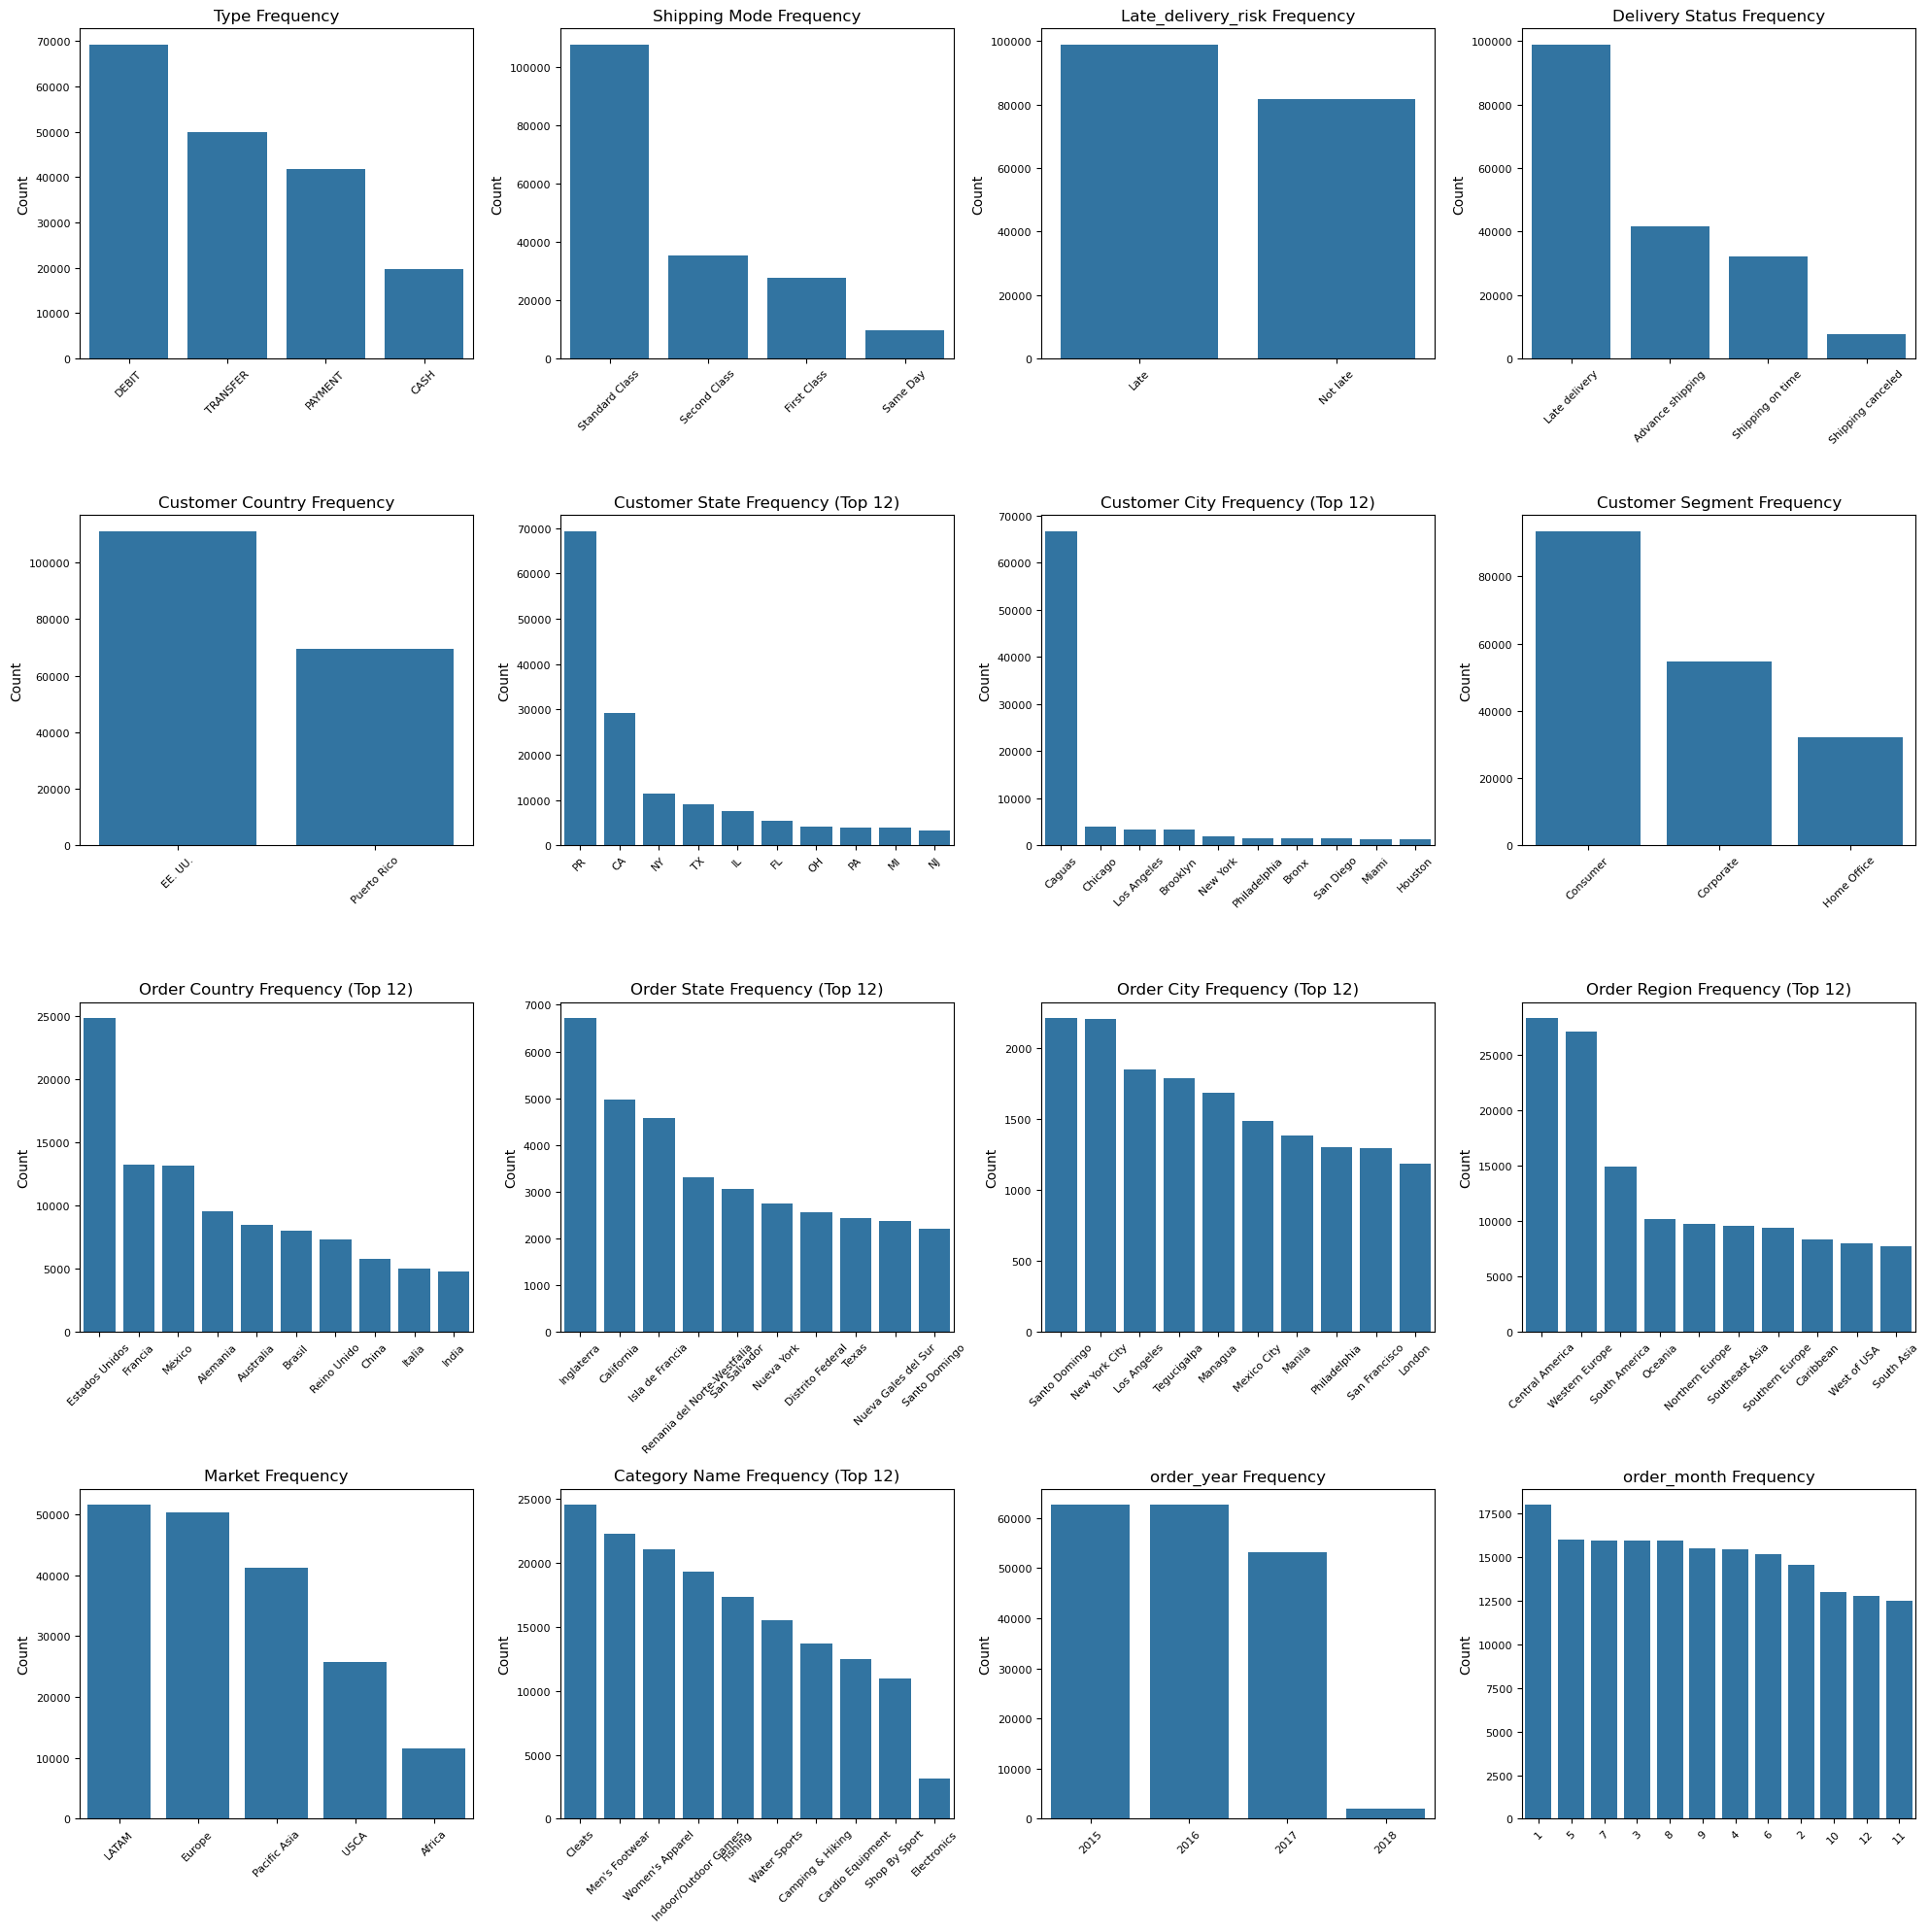

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

cat_vars = [
    'Type', 'Shipping Mode','Late_delivery_risk','Delivery Status', 
    'Customer Country', 'Customer State', 'Customer City', 'Customer Segment', 
    'Order Country', 'Order State', 'Order City','Order Region',  
    'Market','Category Name','order_year', 'order_month'
]

n_cols = 4
n_rows = len(cat_vars) // n_cols + (1 if len(cat_vars) % n_cols != 0 else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, var in enumerate(cat_vars):
    try:
        value_counts = df[var].value_counts()
        if len(value_counts) > 12:
            top_categories = value_counts.head(10).index
            data_filtered = df[df[var].isin(top_categories)]
            title_suffix = " (Top 12)"
        else:
            data_filtered = df
            title_suffix = ""
        
        sns.countplot(data=data_filtered, x=var, ax=axes[i],
                      order=data_filtered[var].value_counts().index)
        
        axes[i].set_title(f'{var} Frequency{title_suffix}', fontsize=12)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].tick_params(axis='y', labelsize=8)
    except:
        axes[i].text(0.5, 0.5, f'Error plotting {var}', transform=axes[i].transAxes, ha='center')
        axes[i].set_title(f'{var} (Error)')

for i in range(len(cat_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


### Numerical Variable Distribution

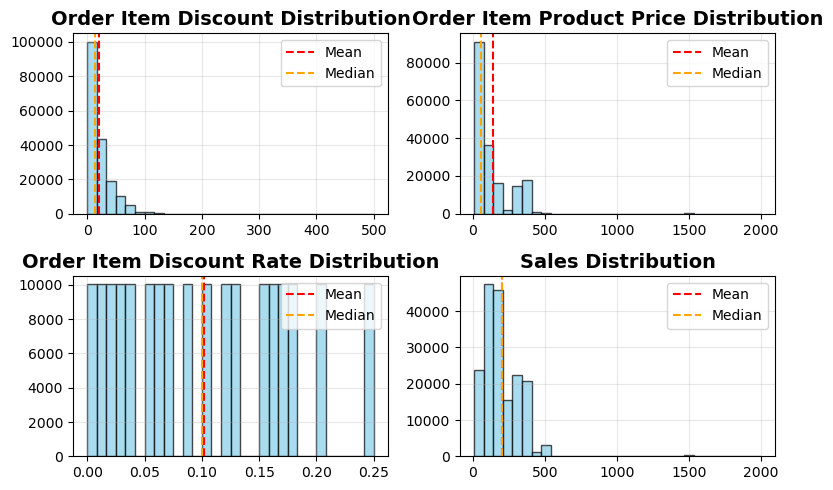

In [15]:
numeric_vars = ['Order Item Discount','Order Item Product Price','Order Item Discount Rate','Sales']

# Histogram + Summary Stats
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.flatten()
for i, var in enumerate(numeric_vars):
    axes[i].hist(df[var], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'{var} Distribution', fontsize=14, fontweight='bold')
    axes[i].axvline(df[var].mean(), color='red', linestyle='--', label='Mean')
    axes[i].axvline(df[var].median(), color='orange', linestyle='--', label='Median')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Subset dataset

In [16]:
#focus on a subset of variables relevant to regional delay analysis and logistics modeling.
df_columns = [
    'Type', 'Shipping Mode','Late_delivery_risk','Delivery Status', 
    'Customer Country', 'Customer State', 'Customer City', 'Customer Segment', 
    'Order Country', 'Order State', 'Order City','Order Region',
    'Market', 'Category Name','order_year', 'order_month',
    'Order Item Discount','Order Item Product Price','Order Item Discount Rate','Sales',
]

def drop_columns(dataset, columns_to_drop):
    dataset = dataset.drop(columns=columns_to_drop)
    print(f"{len(columns_to_drop)} columns dropped successfully. Number of columns remaining: {len(dataset.columns)}")
    return dataset

columns_to_drop = [col for col in df.columns if col not in df_columns]
df_new = drop_columns(df, columns_to_drop)

45 columns dropped successfully. Number of columns remaining: 20


### Correlation Analysis

##### categorical features

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Cramér's V - 0 is no correlation, 1 is strong correlation
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r)-1)))

# main function: to analysis the correlation among all attributes to the target attibutes
def analyze_catvars_with_target(df, cat_vars, target='Delivery Status', p_threshold=0.05):
    results = []
    for var in cat_vars:
        try:
            table = pd.crosstab(df[var], df[target])
            chi2, p, dof, ex = chi2_contingency(table)
            v = cramers_v(df[var], df[target])
            conclusion = "Significant" if p < p_threshold else "Not Significant"
            results.append([var, round(p, 5), round(v, 3), conclusion])
        except Exception as e:
            results.append([var, None, None, f"Error: {str(e)}"])
    
    result_df = pd.DataFrame(results, columns=['Variable', 'p-value', "Cramer's V", 'Conclusion'])
    return result_df.sort_values(by="Cramer's V", ascending=False)



In [18]:
result_df = analyze_catvars_with_target(df_new, cat_vars, target='Delivery Status')
print(result_df)

              Variable  p-value  Cramer's V       Conclusion
2   Late_delivery_risk  0.00000       1.000      Significant
3      Delivery Status  0.00000       1.000      Significant
1        Shipping Mode  0.00000       0.321      Significant
10          Order City  0.00000       0.265      Significant
0                 Type  0.00000       0.198      Significant
9          Order State  0.00000       0.148      Significant
6        Customer City  0.00000       0.105      Significant
8        Order Country  0.00000       0.055      Significant
5       Customer State  0.00000       0.029      Significant
11        Order Region  0.00000       0.021      Significant
13       Category Name  0.67125       0.016  Not Significant
15         order_month  0.00000       0.013      Significant
12              Market  0.00076       0.008      Significant
7     Customer Segment  0.03761       0.006      Significant
14          order_year  0.03692       0.006      Significant
4     Customer Country  

shipping mode, Order city, Order state, Order region, Type, and order state have strong correlation with Delivery Status

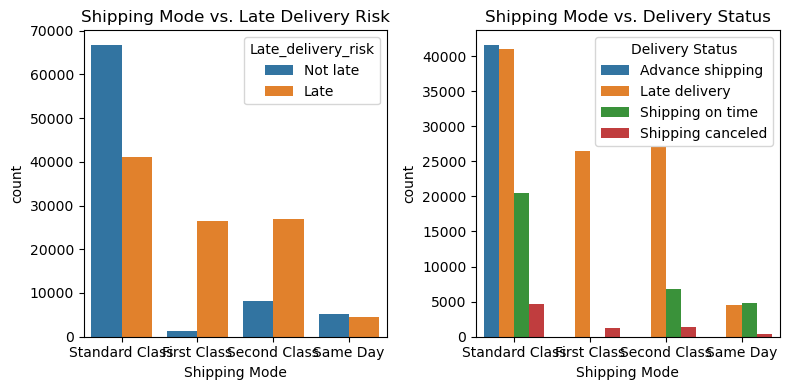

In [19]:
#visualise the value of shipping mode in Delivery Status
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot1：Shipping Mode vs. Late Delivery Risk
sns.countplot(data=df, x='Shipping Mode', hue='Late_delivery_risk', ax=axes[0])
axes[0].set_title("Shipping Mode vs. Late Delivery Risk")

# Plot2：Shipping Mode vs. Delivery Status
sns.countplot(data=df, x='Shipping Mode', hue='Delivery Status', ax=axes[1])
axes[1].set_title("Shipping Mode vs. Delivery Status")

plt.tight_layout()
plt.show()

Most of first and second class are late delivery, which indicates that these two modes of transportation "look advanced", they may have operational or process bottlenecks. Same day mode is more balance between on time delivery and late delivery.

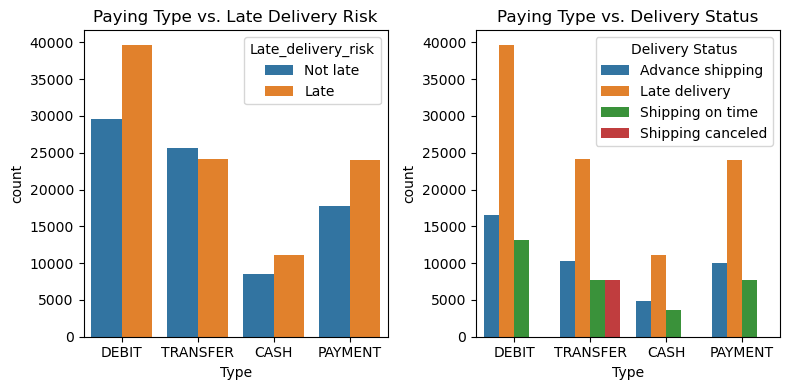

In [20]:
#visualise the value of Paying Type in Delivery Status
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot1：Shipping Mode vs. Late Delivery Risk
sns.countplot(data=df, x='Type', hue='Late_delivery_risk', ax=axes[0])
axes[0].set_title("Paying Type vs. Late Delivery Risk")

# Plot2：Shipping Mode vs. Delivery Status
sns.countplot(data=df, x='Type', hue='Delivery Status', ax=axes[1])
axes[1].set_title("Paying Type vs. Delivery Status")

plt.tight_layout()
plt.show()

##### Numerical features

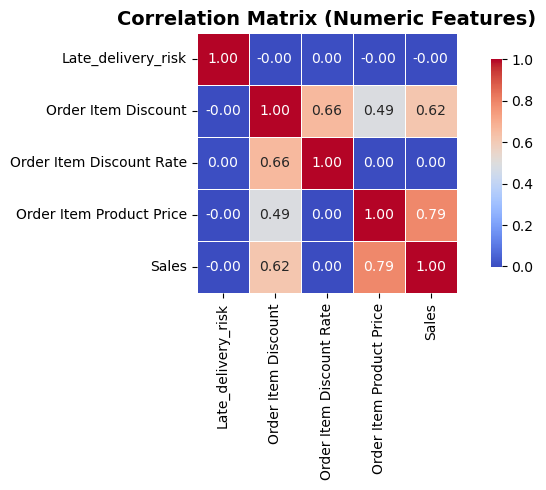

In [21]:
import numpy as np

# Convert target to binary numeric values for correlation
df_corr = df_new.copy()
df_corr['Late_delivery_risk'] = df_corr['Late_delivery_risk'].map({'Late': 1, 'Not late': 0})

# Select only numerical features
num_cols = df_corr.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Add the numeric target
if 'Late_delivery_risk' not in num_cols:
    num_cols.append('Late_delivery_risk')

# Compute correlation matrix
corr_matrix = df_corr[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'shrink': 0.8}, linewidths=0.5)
plt.title('Correlation Matrix (Numeric Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


The variable Late_delivery_risk shows very weak or near-zero correlations with all other numerical features, indicating that it has little to no linear relationship with them.

## Feature Engineering Not Significant

Create a new feature representing the shipping route: From where the customer made the purchase to the destination of the order

In [22]:
df_new['Shipping Route'] = df_new['Customer State'] +  ' → ' + df_new['Order Region']

In [23]:
# Convert all variables that need encoding to strings
df_new['Shipping Mode'] = df_new['Shipping Mode'].astype(str)
df_new['Type'] = df_new['Type'].astype(str)
df_new['Market'] = df_new['Market'].astype(str)
df_new['Customer Segment'] = df_new['Customer Segment'].astype(str)
df_new['order_month'] = df_new['order_month'].astype(str)

In [24]:
df_new['Late_delivery_risk_binary'] = df_new['Late_delivery_risk'].map({'Not late': 0, 'Late': 1})
route_delay_stats = df_new.groupby('Shipping Route')['Late_delivery_risk_binary'].mean().reset_index()
route_delay_stats.columns = ['Shipping Route', 'Route Delay Rate']

# merge back to df
df_new = df_new.merge(route_delay_stats, on='Shipping Route', how='left')

In [25]:
# Calculate the delay rate and number of orders for each route
route_stats = df_new.groupby('Shipping Route')['Late_delivery_risk_binary'].agg(['count', 'mean']).reset_index()
route_stats.columns = ['Shipping Route', 'Order Count', 'Delay Rate']

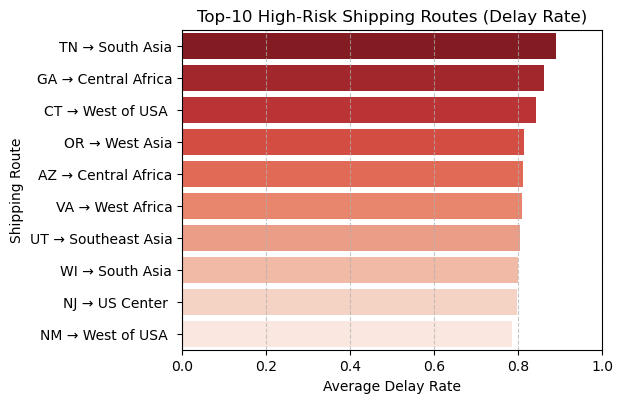

In [26]:
min_order_threshold = 30
top_routes = route_stats[route_stats['Order Count'] >= min_order_threshold]
top_routes = top_routes.sort_values(by='Delay Rate', ascending=False).head(10)

plt.figure(figsize=(6, 4))
sns.barplot(data=top_routes, x='Delay Rate', y='Shipping Route', palette='Reds_r')
plt.title('Top-10 High-Risk Shipping Routes (Delay Rate)')
plt.xlabel('Average Delay Rate')
plt.ylabel('Shipping Route')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.25, right=0.95)
plt.show()

## Modeling - Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Features and target
features = ['Shipping Route', 'Route Delay Rate', 'Shipping Mode', 'Type', 'Market', 'Customer Segment', 'order_month']
X = df_new[features]
y = df_new['Late_delivery_risk'].map({'Late': 1, 'Not late': 0})

# Preprocessing pipeline
preprocessor1 = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), features)
])

# Full pipeline
pipeline1 = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('classifier', LogisticRegression(max_iter=500))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Fit the model
pipeline1.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Modeling Evaluation

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

def evaluate_model(pipeline, X_test, y_test, model_name='Model'):
    """
    Evaluate classification model performance with classification report,
    confusion matrix, AUC score, and ROC curve.

    Parameters:
    - pipeline: fitted pipeline object (with predict and predict_proba)
    - X_test: test features
    - y_test: true labels
    - model_name: optional name of the model (string)
    """
    
    # prediction
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]  #AUC

    # evaluate index
    print("Classification Report:\n", classification_report(y_test, y_pred))
    # AUC Score
    print("=== AUC Score: ===\n", roc_auc_score(y_test, y_proba))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Not Late', 'Late']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=axes[1])
    axes[1].set_title(f'{model_name} - ROC Curve')

    plt.tight_layout()
    plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.84      0.71     20386
           1       0.81      0.58      0.68     24744

    accuracy                           0.70     45130
   macro avg       0.72      0.71      0.70     45130
weighted avg       0.73      0.70      0.69     45130

=== AUC Score: ===
 0.7526511624229797


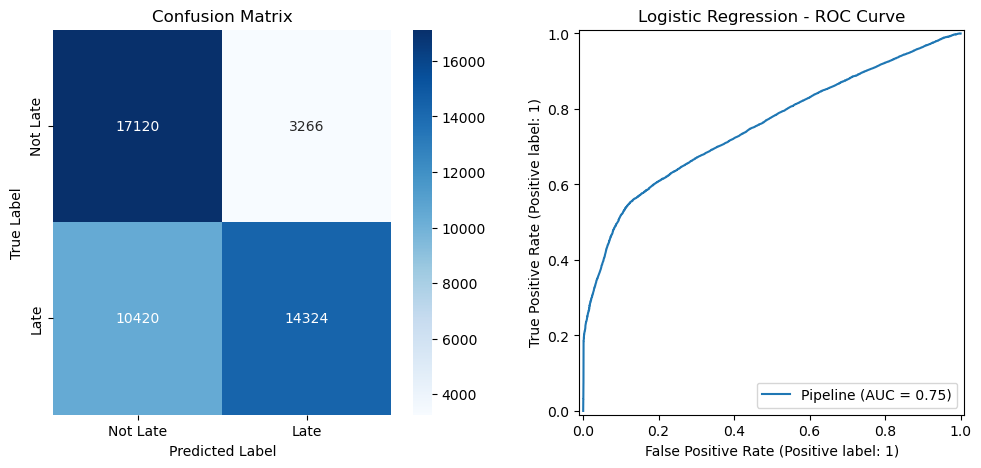

<Figure size 600x400 with 0 Axes>

In [29]:
evaluate_model(pipeline1, X_test, y_test, model_name='Logistic Regression')

The logistic regression model achieved moderate performance with 71% accuracy and an AUC of 0.75, indicating reasonable ability to distinguish between late and on-time deliveries.

## Modeling - RandomForest

In [30]:
numeric_features = ['Route Delay Rate']

In [31]:
categorical_features = ['Shipping Mode', 'Type', 'Market', 'Customer Segment', 'Shipping Route', 'order_month']

In [32]:
# Preprocessor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

preprocessor_rf = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

In [33]:
X = df_new[numeric_features + categorical_features]
y = df_new['Late_delivery_risk'].map({'Late': 1, 'Not late': 0})

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# model training
pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.79     20386
           1       0.86      0.73      0.79     24744

    accuracy                           0.79     45130
   macro avg       0.79      0.80      0.79     45130
weighted avg       0.80      0.79      0.79     45130

=== AUC Score: ===
 0.8817710524415159


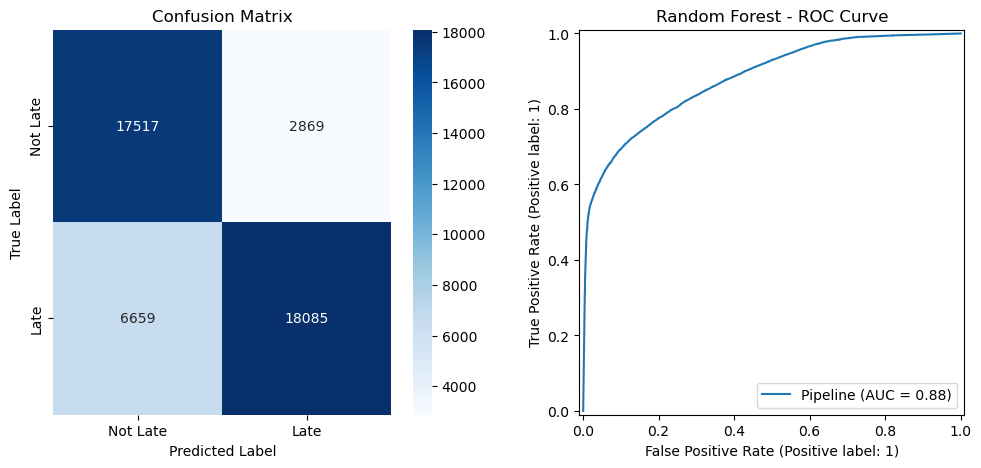

<Figure size 600x400 with 0 Axes>

In [34]:
evaluate_model(pipeline_rf, X_test, y_test, model_name='Random Forest')

## Model Comparison: Logistic Regression vs. Random Forest

To evaluate the performance of different models in predicting delivery delays (`Late_delivery_risk`), I compared **Logistic Regression** and **Random Forest** using the same test dataset.
44

### Key Metrics Performance

| Metric              | Logistic Regression | Random Forest |
|---------------------|---------------------|----------------|
| Accuracy            |00.71                | 790.80**       |
| AUC Score           75.778                | **0.88**      |
| Precision (Late)    810.79                | **0.86**       |
| Recall (Late)       580.64                | **0.73**       |
| F1-score (Late)     680.71                | **0.79**       |

### Interpretation

- **Random Forest outperforms Logistic Regression** across all evaluation met, especially in recall and AUC score.
- Logistic Regression fails to capture many late deliveries (recall = 0.58), while Random Forest identifies a much higher proportion (recall = 0.73).
- The higher AUC (0.88) of Random Forest shows better ability to distinguish between late and on-time deliveries.
- Confusion matrix confirms that Random Forest reduces both false positives and false negatives compared to Logistic Regression.sk.


## Model Feature Importance Analysis

To understand which variables have the most significant impact on delivery delay predictions, this section provides multiple methods to identify and visualize the most important features in our trained random forest model.

In [37]:
# Get OneHot encoded feature names from the pipeline
ohe = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine numeric and encoded categorical feature names
all_feature_names = numeric_features + list(ohe_feature_names)

# Get feature importances from the trained Random Forest model
importances = pipeline_rf.named_steps['classifier'].feature_importances_

# Build a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 most important features
print("TOP 20 MOST IMPORTANT FEATURES:")
print("=" * 80)
print(f"{'Rank':<4} {'Feature':<60} {'Importance':<12}")
print("=" * 80)

for idx, (_, row) in enumerate(feature_importance.head(20).iterrows(), 1):
    name = row['Feature'][:57] + "..." if len(row['Feature']) > 60 else row['Feature']
    print(f"{idx:<4} {name:<60} {row['Importance']:<12.4f}")

print("=" * 80)

TOP 20 MOST IMPORTANT FEATURES:
Rank Feature                                                      Importance  
1    Shipping Mode_Standard Class                                 0.1617      
2    Shipping Mode_First Class                                    0.1289      
3    Route Delay Rate                                             0.0804      
4    Shipping Mode_Second Class                                   0.0572      
5    Customer Segment_Consumer                                    0.0291      
6    Customer Segment_Corporate                                   0.0255      
7    Customer Segment_Home Office                                 0.0214      
8    Shipping Mode_Same Day                                       0.0161      
9    order_month_1                                                0.0153      
10   order_month_6                                                0.0130      
11   order_month_8                                                0.0119      
12   Type_DEBIT     

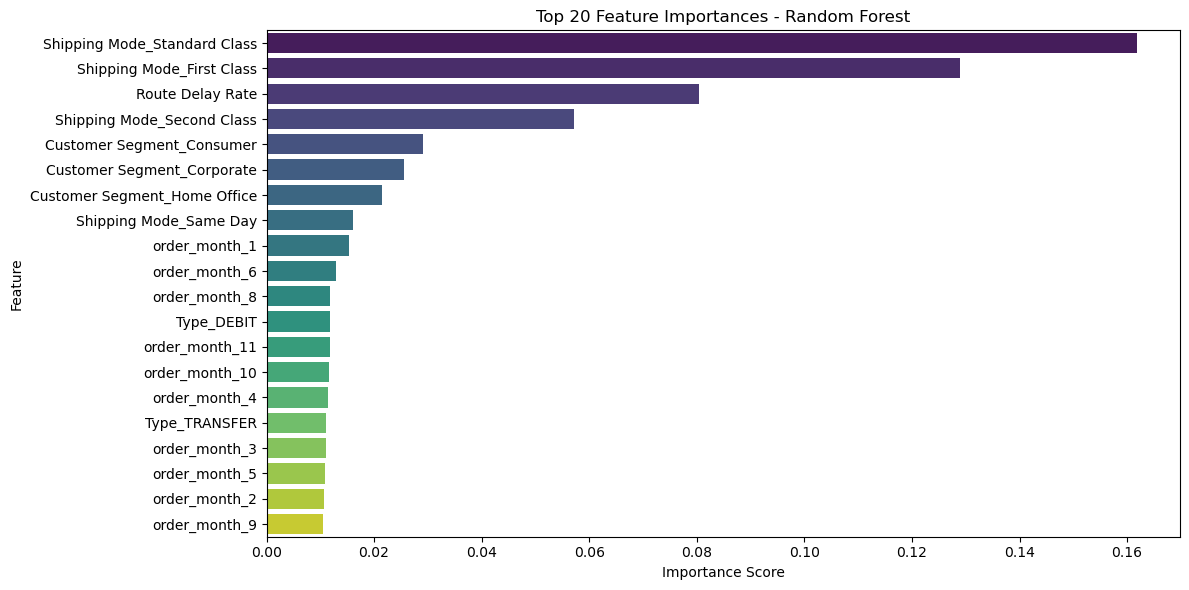

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Feature Importance Summary (Random Forest)

The top features influencing delivery delay prediction include:

- **Shipping Mode**: Different delivery options have the highest impact, especially "Standard Class" and "First Class".
- **Route Delay Rate**: The engineered feature capturing historical delay risk by route ranks #3, demonstrating its strong predictive power.
- **Customer Segment**: End-customer type plays a key role in delivery performance.
- **Order Month**: Seasonality appears significant, with specific months more prone to delays.

These insights suggest that both operational choices (shipping mode, customer segment) and route-level historical performance are key to predicting late deliveries.
